# Mini-projeto 4: Intervalo de confiança usando Bootstrap

In [474]:
import numpy as np
import random as rnd
import math
import matplotlib.pyplot as plt

In [475]:
cont_dist2 = lambda n,z: n*(z**(n-1))

In [476]:
def get_extreme_values_dist(N, N_samples):
    N_extreme = np.zeros(N_samples)

    for x in range(N_samples):
        X = []
        r = 1
        for i in range(N):
            X.append(rnd.random())
            r *= X[i]
            
        Z = max(X)
        if (r <= Z):
            N_extreme[x] += Z
        
    return N_extreme

In [477]:
N4_ext = get_extreme_values_dist(4, 100000)

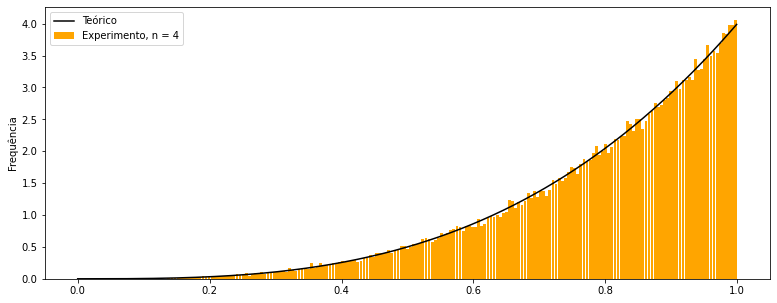

In [478]:
plt.figure(figsize=(13,5))
X = [i*0.001 for i in range(0,1000)]

plt.plot(X, [cont_dist2(4, i) for i in X], 'k-', label="Teórico")

plt.ylabel('Frequência')

plt.hist(N4_ext, bins=200, density=True, color='orange', rwidth=.9, label='Experimento, n = 4')
plt.legend()
plt.show()

In [502]:
def get_cumulative_dist(dist_sorted, N):
    X = [i*(1/N) for i in range(0,N)]
    
    N4_ext_cum = []
    c = 0
    j=0
    for i in range(len(X)):
        while j < N and dist_sorted[j] <= X[i]:
            #print(j, N4_ext[j], X[i])
            j+=1
            c+=1/N
        N4_ext_cum.append(c)
        
    return X, N4_ext_cum

In [503]:
N = 100000
N4_ext = get_extreme_values_dist(4, N+1)
N4_ext.sort()

X, N4_ext_cum = get_cumulative_dist(N4_ext, N)

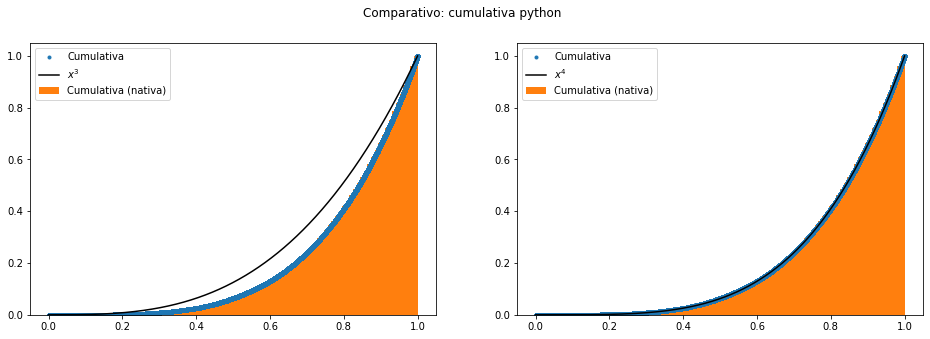

In [504]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,5))
plt.suptitle("Comparativo: cumulativa python")

ax1.plot(X, N4_ext_cum, '.', label='Cumulativa')
ax1.plot(X, [cont_dist2(4, i)/4 for i in X], 'k-', label=r"$x^3$")
ax1.hist(N4_ext, bins=100, cumulative=True, density=True, label='Cumulativa (nativa)')
ax1.legend()

ax2.plot(X, N4_ext_cum, '.', label='Cumulativa')
ax2.plot(X, [cont_dist2(5, i)/5 for i in X], 'k-', label=r"$x^4$")
ax2.hist(N4_ext, bins=100, cumulative=True, density=True, label='Cumulativa (nativa)')

ax2.legend()
plt.show()

In [505]:
exact_error = lambda n, alpha: np.sqrt((1/(2*n)) * np.log(2/alpha))

In [506]:
N = 100
N4_ext = get_extreme_values_dist(4, N+1)
N4_ext.sort()

X, N4_ext_cum = get_cumulative_dist(N4_ext, N)

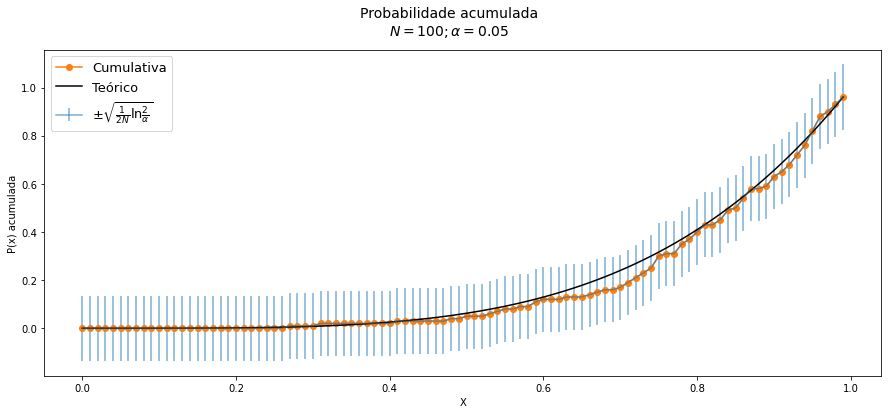

In [507]:
plt.figure(figsize=(15,6))
plt.suptitle("Probabilidade acumulada\n" + r"$N = 100; \alpha = 0.05$", fontsize=14)
epsilon = exact_error(N, 0.05)
plt.errorbar(X, N4_ext_cum, yerr=epsilon, alpha=.6, label=r'$\pm \sqrt{\frac{1}{2N} \ln{\frac{2}{\alpha}}}$')
plt.plot(X, N4_ext_cum, 'o-', label='Cumulativa')
plt.plot(X, [cont_dist2(5, i)/5 for i in X], 'k-', label="Teórico")

plt.ylabel("P(x) acumulada")
plt.xlabel('X')
plt.legend(fontsize=13)
plt.show()

### Probabilidade: método plug-in para N=10e5

In [508]:
theta_big = 0
i = 0
for i in range(N):
    X_i = rnd.choice(N4_ext)
    if X_i <= 3/4:
        theta_big+=1/N
    i+=1
theta_big = 1-theta_big
print("P(x>3/4) = ", theta_big)

P(x>3/4) =  0.69


Sendo o valor teórico, para $f(z) = nz^{n-1}$ e n=4 (normalizado)

$$
\begin{equation}
\int^x f(x) dx = \int_{0}^{x} t^3 dt$
\end{equation}
$$

Para $P(X > 3/4) = 1 - P (X \leq 3/4)$,

$$
\begin{equation}
P(X > 3/4) = 1 - \int_{0}^{0.75} t^3 dt = 0,683
\end{equation}
$$

In [509]:
THETA = 0.683

### Análise usando estimador plug-in e bootstrap para o intervalo de confiança

In [529]:
def get_bootstrap_estimators(dist_sorted_original, N, B):    
    theta_boot = []
    for b in range(B):
        boot_i = rnd.choices(list(dist_sorted_original), k=N)
        boot_i.sort()
        
        theta_i = 0
        
        for j in range(N):
            X_j = rnd.choice(boot_i)
            if X_j <= 3/4:
                theta_i+=1/N
        theta_i = 1-theta_i
        theta_boot.append(theta_i)
        
    theta_boot.sort()
    X, theta_cumsum = get_cumulative_dist(theta_boot, B)
    
    quartil_1 = 0
    quartil_4 = 0
    for i in range(B):
        if theta_cumsum[i] <= 0.025:
            quartil_1 = i/B
        if theta_cumsum[i] <= 0.975:
            quartil_4 = i/B
            
    
    return X, theta_boot, theta_cumsum, quartil_1, quartil_4

In [530]:
N = 100
N4_ext = get_extreme_values_dist(4, N)
N4_ext.sort()

theta = 0
for i in range(N):
    X_i = rnd.choice(N4_ext)
    if X_i <= 3/4:
        theta+=1/N
theta = 1-theta

### Considerando N = 100

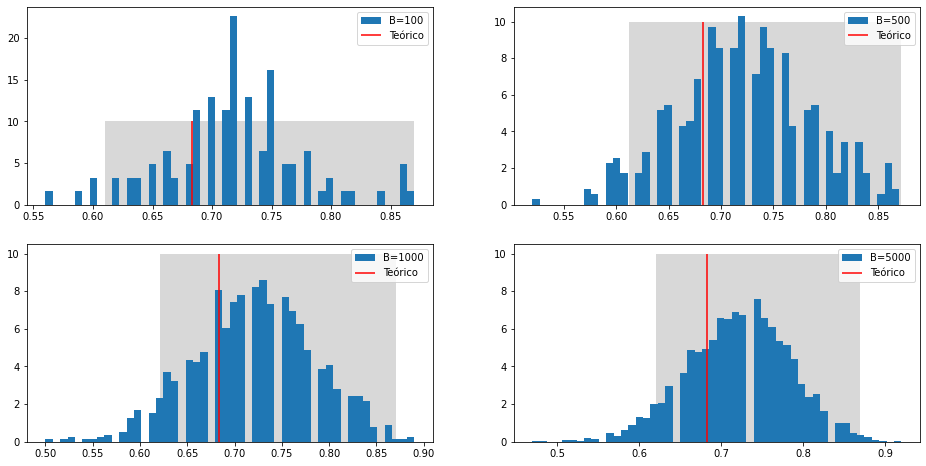

In [531]:
fig, axs = plt.subplots(2,2,figsize=(16,8))

N = len(N4_ext)

B=100
thetas_boot = get_bootstrap_estimators(N4_ext, N, B)
axs[0][0].hist(thetas_boot[1], bins=50, density=True, label='B=100')
axs[0][0].fill_betweenx([0,10], 2*theta - thetas_boot[3], 2*theta - thetas_boot[4], facecolor='grey', alpha=.3)
axs[0][0].vlines(THETA, 0, 10, label='Teórico', colors='r')

axs[0][0].legend()

B=500
thetas_boot = get_bootstrap_estimators(N4_ext, N, B)
axs[0][1].hist(thetas_boot[1], bins=50, density=True, label='B=500')
axs[0][1].fill_betweenx([0,10], 2*theta - thetas_boot[3], 2*theta - thetas_boot[4], facecolor='grey', alpha=.3)
axs[0][1].vlines(THETA, 0, 10, label='Teórico', colors='r')

axs[0][1].legend()

B=1000
thetas_boot = get_bootstrap_estimators(N4_ext, N, B)
axs[1][0].hist(thetas_boot[1], bins=50, density=True, label='B=1000')
axs[1][0].fill_betweenx([0,10], 2*theta - thetas_boot[3], 2*theta - thetas_boot[4], facecolor='grey', alpha=.3)
axs[1][0].vlines(THETA, 0, 10, label='Teórico', colors='r')

axs[1][0].legend()

B=5000
thetas_boot = get_bootstrap_estimators(N4_ext, N, B)
axs[1][1].hist(thetas_boot[1], bins=50, density=True, label='B=5000')
axs[1][1].fill_betweenx([0,10], 2*theta - thetas_boot[3], 2*theta - thetas_boot[4], facecolor='grey', alpha=.3)
axs[1][1].vlines(THETA, 0, 10, label='Teórico', colors='r')

axs[1][1].legend()

plt.show()

### Considerando N = 10e3

In [534]:
N = 1000
N4_ext = get_extreme_values_dist(4, N)
N4_ext.sort()

theta = 0
for i in range(N):
    X_i = rnd.choice(N4_ext)
    if X_i <= 3/4:
        theta+=1/N
theta = 1-theta

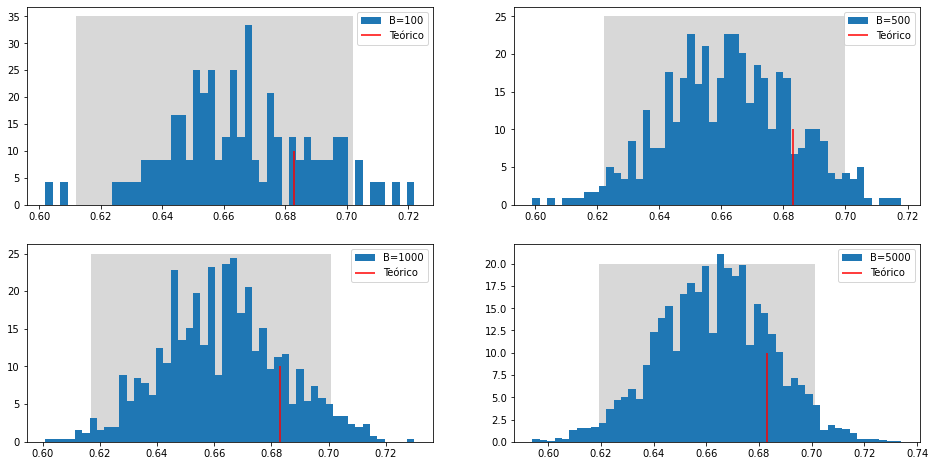

In [535]:
fig, axs = plt.subplots(2,2,figsize=(16,8))

N = len(N4_ext)

B=100
thetas_boot = get_bootstrap_estimators(N4_ext, N, B)
axs[0][0].hist(thetas_boot[1], bins=50, density=True, label='B=100')
axs[0][0].fill_betweenx([0,35], 2*theta - thetas_boot[3], 2*theta - thetas_boot[4], facecolor='grey', alpha=.3)
axs[0][0].vlines(THETA, 0, 10, label='Teórico', colors='r')

axs[0][0].legend()

B=500
thetas_boot = get_bootstrap_estimators(N4_ext, N, B)
axs[0][1].hist(thetas_boot[1], bins=50, density=True, label='B=500')
axs[0][1].fill_betweenx([0,25], 2*theta - thetas_boot[3], 2*theta - thetas_boot[4], facecolor='grey', alpha=.3)
axs[0][1].vlines(THETA, 0, 10, label='Teórico', colors='r')

axs[0][1].legend()

B=1000
thetas_boot = get_bootstrap_estimators(N4_ext, N, B)
axs[1][0].hist(thetas_boot[1], bins=50, density=True, label='B=1000')
axs[1][0].fill_betweenx([0,25], 2*theta - thetas_boot[3], 2*theta - thetas_boot[4], facecolor='grey', alpha=.3)
axs[1][0].vlines(THETA, 0, 10, label='Teórico', colors='r')

axs[1][0].legend()

B=5000
thetas_boot = get_bootstrap_estimators(N4_ext, N, B)
axs[1][1].hist(thetas_boot[1], bins=50, density=True, label='B=5000')
axs[1][1].fill_betweenx([0,20], 2*theta - thetas_boot[3], 2*theta - thetas_boot[4], facecolor='grey', alpha=.3)
axs[1][1].vlines(THETA, 0, 10, label='Teórico', colors='r')

axs[1][1].legend()

plt.show()

### Considerando N = 10e4

In [471]:
N = 10000
N4_ext = get_extreme_values_dist(4, N)
N4_ext.sort()

theta = 0
for i in range(N):
    X_i = rnd.choice(N4_ext)
    if X_i <= 3/4:
        theta+=1/N
theta = 1-theta

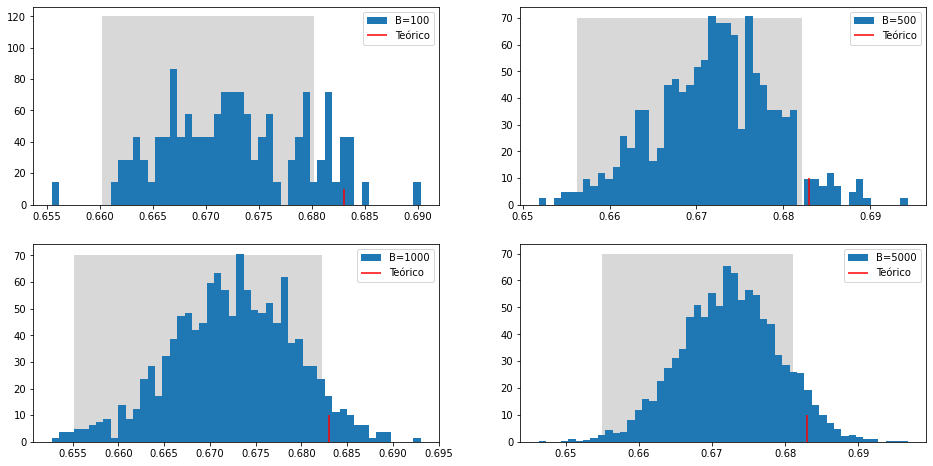

In [473]:
fig, axs = plt.subplots(2,2,figsize=(16,8))

N = len(N4_ext)

B=100
thetas_boot = get_bootstrap_estimators(N4_ext, N, B)
axs[0][0].hist(thetas_boot[1], bins=50, density=True, label='B=100')
axs[0][0].fill_betweenx([0,120], 2*theta - thetas_boot[3], 2*theta - thetas_boot[4], facecolor='grey', alpha=.3)
axs[0][0].vlines(THETA, 0, 10, label='Teórico', colors='r')

axs[0][0].legend()

B=500
thetas_boot = get_bootstrap_estimators(N4_ext, N, B)
axs[0][1].hist(thetas_boot[1], bins=50, density=True, label='B=500')
axs[0][1].fill_betweenx([0,70], 2*theta - thetas_boot[3], 2*theta - thetas_boot[4], facecolor='grey', alpha=.3)
axs[0][1].vlines(THETA, 0, 10, label='Teórico', colors='r')

axs[0][1].legend()

B=1000
thetas_boot = get_bootstrap_estimators(N4_ext, N, B)
axs[1][0].hist(thetas_boot[1], bins=50, density=True, label='B=1000')
axs[1][0].fill_betweenx([0,70], 2*theta - thetas_boot[3], 2*theta - thetas_boot[4], facecolor='grey', alpha=.3)
axs[1][0].vlines(THETA, 0, 10, label='Teórico', colors='r')

axs[1][0].legend()

B=5000
thetas_boot = get_bootstrap_estimators(N4_ext, N, B)
axs[1][1].hist(thetas_boot[1], bins=50, density=True, label='B=5000')
axs[1][1].fill_betweenx([0,70], 2*theta - thetas_boot[3], 2*theta - thetas_boot[4], facecolor='grey', alpha=.3)
axs[1][1].vlines(THETA, 0, 10, label='Teórico', colors='r')

axs[1][1].legend()

plt.show()